# Design space exploration

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

plt.rcParams.update(
    {
        "text.usetex": True,
        "font.family": "sans-serif",
        "font.sans-serif": ["Times New Roman"],
    }
)
plt.rcParams["font.family"] = "Times New Roman"

## Complex posterior distribution

Picture yourself traversing a terrain with numerous peaks and valleys, akin to navigating a complex multi-modal Gaussian distribution. In this analogy, optimisation corresponds to seeking out the highest summit, akin to finding the global maximum, which represents the optimal solution. It focuses on pinpointing the singular best point amidst the landscape, much like identifying the highest peak. Conversely, MCMC mirrors the process of surveying the entire topography, encompassing all peaks and troughs. Instead of solely homing in on the highest point, MCMC explores the full distribution, capturing the intricacies of the landscape. Thus, while optimisation targets the global maximum, MCMC methodically maps out the complete distribution, analogous to exploring the entirety of the terrain.

**Banana:**

Below is a simple implementation of a banana-shaped posterior distribution. This function creates a banana-shaped posterior distribution by combining a quadratic term $(x_2 - x_1^2)^2$ with a Gaussian-like term $(x_1 - 2)^2$, exponentiated to ensure positivity. Adjusting the coefficients and terms can modify the shape and size of the "banana".

In [2]:
def banana(x):
    x1, x2 = x
    return np.exp(-0.1 * ((x2 - x1**2) ** 2 + (x1 - 2) ** 2))

In [3]:
def double_banana(x, peaks=(1.0, 1.5), offsets=(0.0, 6.0), scales=(0.1, 0.2), curvatures=(-1, 1)):
    x1, x2 = x
    bananas = [
        peak * np.exp(-scale * ((x2 - curvature * (x1 - offset)**2) ** 2 + (x1 - offset - 2) ** 2))
        for peak, offset, scale, curvature in zip(peaks, offsets, scales, curvatures)
    ]
    return sum(bananas)

In [4]:
def weighted_multi_gaussian_mixture(x):
    x1, x2 = x
    means = [(0, 0), (2, 7), (5, 4)]
    stds = [1.5, 0.5, 1]
    weights = [0.3, 0.8, 0.2]
    return sum(
        w * np.exp(-((x1 - mean[0]) ** 2 + (x2 - mean[1]) ** 2) / (2 * std**2))
        for mean, std, w in zip(means, stds, weights)
    )

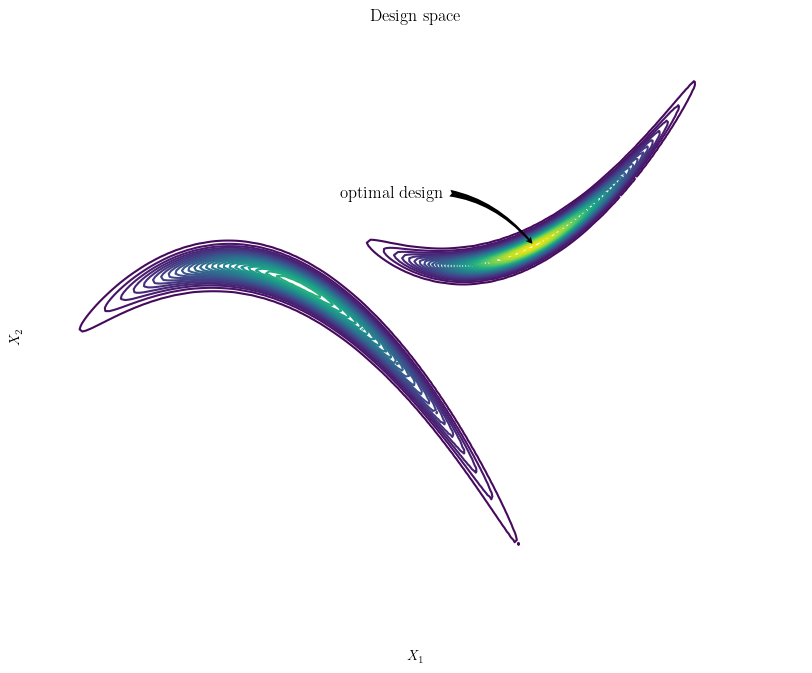

In [5]:
x1_range = np.linspace(-5, 15, 200)
x2_range = np.linspace(-80, 50, 200)
X1, X2 = np.meshgrid(x1_range, x2_range)
Z = np.array([[double_banana((x1, x2)) for x1 in x1_range] for x2 in x2_range])
Z = np.where(Z > 0.01, Z, np.nan)

max_index = np.unravel_index(np.nanargmax(Z), Z.shape)
x1_max, x2_max = X1[max_index], X2[max_index]

plt.figure(figsize=(10, 8))
plt.contour(X1, X2, Z, levels=40, cmap='viridis')
plt.xlabel('$X_1$')
plt.ylabel('$X_2$')
plt.title('Design space')
plt.gca().set_frame_on(False)
plt.xticks([])
plt.yticks([])

plt.annotate(
    'optimal design',
    xy=(x1_max, x2_max),
    xytext=(x1_max - 5, x2_max + 10),
    fontsize=12,
    ha='left',
    color='black',
    arrowprops=dict(
        arrowstyle='fancy',
        connectionstyle='arc3,rad=-0.3',
        facecolor='black',
        edgecolor='none'
    )
)

plt.savefig('design-space.png', dpi=300, bbox_inches='tight')

## Grid search

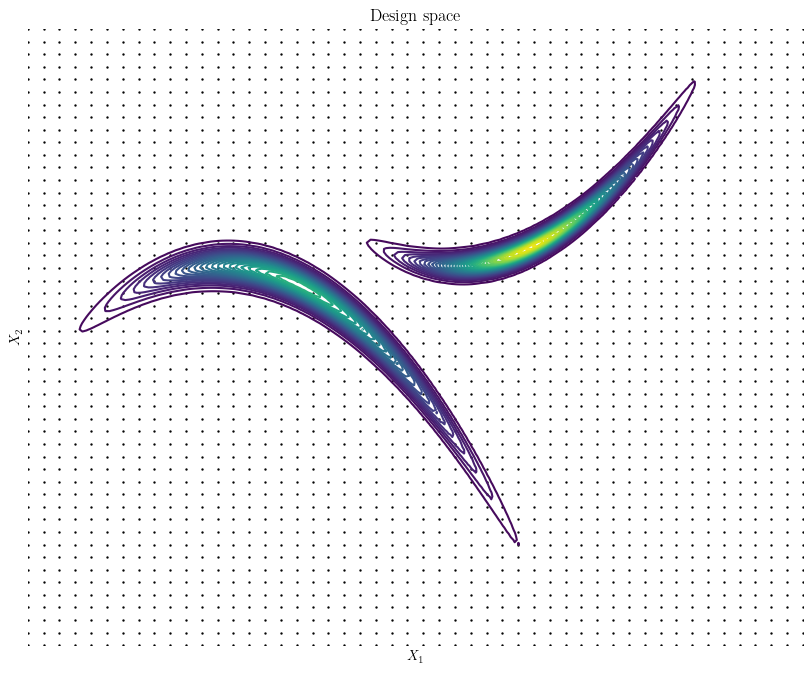

In [6]:
x1_search = np.linspace(-5, 15, 50)
x2_search = np.linspace(-80, 50, 50)
X1_search, X2_search = np.meshgrid(x1_search, x2_search)

plt.figure(figsize=(10, 8))
plt.contour(X1, X2, Z, levels=40, cmap='viridis')
plt.scatter(X1_search, X2_search, s=0.5, color='black')
plt.xlabel('$X_1$')
plt.ylabel('$X_2$')
plt.title('Design space')
plt.gca().set_frame_on(False)
plt.xticks([])
plt.yticks([])
plt.savefig('grid-search.png', dpi=300, bbox_inches='tight')

## Monte Carlo

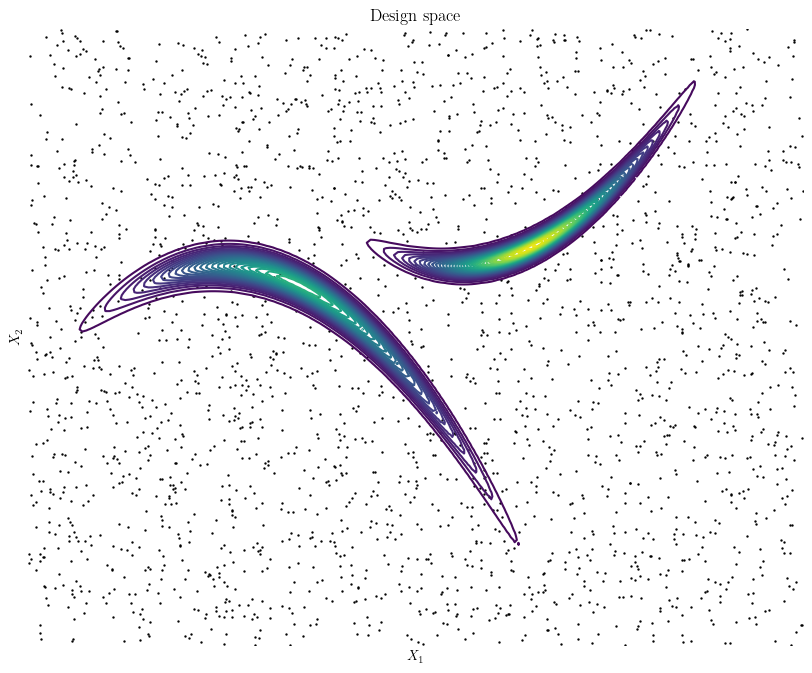

In [9]:
X1_mc = np.random.uniform(-5, 15, 2500)
X2_mc = np.random.uniform(-80, 50, 2500)

plt.figure(figsize=(10, 8))
plt.contour(X1, X2, Z, levels=40, cmap='viridis')
plt.scatter(X1_mc, X2_mc, s=0.5, color='black')
plt.xlabel('$X_1$')
plt.ylabel('$X_2$')
plt.title('Design space')
plt.gca().set_frame_on(False)
plt.xticks([])
plt.yticks([])
plt.savefig('monte-carlo.png', dpi=300, bbox_inches='tight')

## Adaptive Metropolis Hastings (`Sampler` and `Proposal` class)

In [ ]:
from tqdm import tqdm


class Sampler:

    def __init__(self, posterior, proposal, steps, init):
        self.posterior = posterior
        self.proposal = proposal
        self.steps = int(steps)  # n_samples
        self.init = init
        self.samples = None

    def sample(self):
        """
        Sampling
        """
        self.samples = [self.init.copy()]
        for _ in tqdm(range(self.steps), desc="Sampling"):
            self._sample_step()

    def get_samples(self):
        """
        Returns the samples
        """
        return np.array(self.samples)

    def _sample_step(self):
        """
        Draw a new sample
        """
        point = self.samples[-1]
        proposal = self.proposal.draw(self.samples)
        self.samples.append(self._accept_or_reject(point, proposal))

    def _accept_or_reject(self, x_i, x_p):
        """
        Accept of reject a new candidate

        Parameters
        ----------
        x_i : ndarray
            Current sample

        x_p : ndarray
            New sample (x_p) is proposed by drawing from a proposal
            distribution

        n_accept : int
            Count of accepted samples

        Returns
        -------

        """
        alpha = self._compute_acceptance_ratio(x_i, x_p)
        u = np.random.uniform(low=0.0, high=1.0)
        if u <= alpha:  # Accept proposal
            return x_p
        else:  # Reject proposal
            return x_i

    def _compute_acceptance_ratio(self, x_i, x_p):
        return min(1, self.posterior.evaluate(x_p) / self.posterior.evaluate(x_i))


class MetropolisHastings(Sampler):
    pass

In [ ]:
class Proposal:
    """
    Proposal class

    TODO: look at pysampler/proposal.py
    """

    def __init__(self, step_size):
        self.step_size = step_size

    def draw(self, samples):
        return np.random.normal(samples[-1], self.step_size)


class GaussianProposal(Proposal):
    pass


class AdaptiveProposal:
    """
    Adaptive proposal class - update the the covariance matrix of the proposal
    distribution using existing knowledge of the posterior

    Haario, H., Saksman, E., and Tamminen, J. (1999). Adaptive proposal
    distribution for random walk metropolis algorithm. Computational
    Statistics, 14(3):375-395. 1, 2

    Attributes
    ----------
    update_freq: int
        Proposal distribution update frequency (default = 1000). The
        frequency at which the proposal distribution is updated.

    n_K : ndarray
        Number of samples / update frequency

    R_0 : ndarray (floats)
        Initial covariance matrix (this can be chosen as the identify matrix
        if you have no prior knowledge)

    R_t : ndarray (floats)
        Updated covariance matrix

    i : int
        Counter to track how many times the proposal has been called

    Notes
    -----
    - TODO: is n_K equal to n_samples?
    - TODO: gamma is missing from the draw method
    """

    def __init__(self, cov, step_size=2.38, update_freq=1000):
        self.cov = cov
        self.step_size = step_size
        self.update_freq = update_freq
        self.R_t = cov
        self.i = 0

    def draw(self, samples):
        """
        Draw x (candidate) from proposal distribution q

        Parameters
        ----------
        x_i : ndarray
            Current sample

        Returns
        -------
        x_p : ndarray
            Proposed sample (candidate sample)

        """
        self.i += 1
        if self.i % self.update_freq == 0:
            self._adapt_cov(samples)
        return np.random.multivariate_normal(samples[-1], self.R_t)

    def _adapt_cov(self, K):
        """
        Parameters
        ----------
        K : ndarray

        Returns
        -------
        R_t : ndarray (floats)
            Updated covariance matrix
        """
        K_tilde = self._compute_K_tilde(K)
        self.R_t = (1 / (len(K) - 1)) * np.matmul(np.transpose(K_tilde), K_tilde)

    def _compute_K_tilde(self, K):
        """
        Calculate the centred matrix

        Parameters
        ----------
        K : ndarray
            Sample chain - all previous samples are stored in matrix K of size
            n_k x n_p, where n_k is... and n_p is the number of unknown
            parameters. Each row represents one sampled point.

        K_mean : ndarray
            History (evolution) of mean value of all previous samples
            (n_samples x n_p)

        Returns
        -------
        K_tilde : ndarray
            The centred matrix n_K x n_p (K_tilde = K - E[K])
        """
        return K - np.mean(K, 0)

In [ ]:
class Posterior:

    def __init__(self, distribution):
        self.distribution = distribution

    def evaluate(self, x):
        """
        Compute the posterior distribution for given model parameters and observed data.

        Parameters
        ----------
        x : float or array-like
            The value(s) of the model parameters.

        Returns
        -------
        float or array-like
            The posterior probability distribution for the given model parameters.
        """
        return self.distribution(x)

In [ ]:
posterior = Posterior(distribution=double_banana)
proposal = AdaptiveProposal(cov=np.eye(2), step_size=[1, 1])
mh = Sampler(posterior, proposal, 1e5, np.array([0, 10]))
mh.sample()
samples = mh.get_samples()

In [ ]:
def scatter_hist(x, y, p, ax, ax_histx, ax_histy):
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    ax.scatter(x, y, s=1, c=p)

    xbinwidth = (np.max(x) - np.min(x)) / 100
    ybinwidth = (np.max(y) - np.min(y)) / 100
    xbins = np.arange(np.min(x), np.max(x) + xbinwidth, xbinwidth)
    ybins = np.arange(np.min(y), np.max(y) + ybinwidth, ybinwidth)
    ax_histx.hist(x, bins=xbins, density=True, histtype="step")
    ax_histy.hist(
        y, bins=ybins, density=True, histtype="step", orientation="horizontal"
    )

In [ ]:
fig = plt.figure(layout="constrained")
ax = fig.add_gridspec(top=0.75, right=0.75).subplots()
ax_histx = ax.inset_axes([0, 1.05, 1, 0.25], sharex=ax)
ax_histy = ax.inset_axes([1.05, 0, 0.25, 1], sharey=ax)
p = [
    posterior.evaluate(sample) for sample in samples
]  # TODO: save this in the Sampler class
scatter_hist(samples[:, 0], samples[:, 1], p, ax, ax_histx, ax_histy)

In [ ]:
posterior = Posterior(distribution=weighted_multi_gaussian_mixture)
proposal = AdaptiveProposal(cov=np.eye(2), step_size=[1, 1])
mh = Sampler(posterior, proposal, 1e5, np.array([0, 10]))
mh.sample()
samples = mh.get_samples()

In [ ]:
fig = plt.figure(layout="constrained")
ax = fig.add_gridspec(top=0.75, right=0.75).subplots()
ax_histx = ax.inset_axes([0, 1.05, 1, 0.25], sharex=ax)
ax_histy = ax.inset_axes([1.05, 0, 0.25, 1], sharey=ax)
p = [
    posterior.evaluate(sample) for sample in samples
]  # TODO: save this in the Sampler class
scatter_hist(samples[:, 0], samples[:, 1], p, ax, ax_histx, ax_histy)

## Optimisation

In [ ]:
class GradientDescent:

    def __init__(self, posterior, initial_candidate):
        self.posterior = posterior
        self.candidate = initial_candidate

    def optimise(self, step_size, n_steps=100):
        """
        Optimise the cost function using gradient descent.

        Parameters:
        step_size (float): Learning rate for the gradient descent.
        n_steps (int): Number of iterations for the gradient descent.

        Returns:
        """
        cost_hist = []
        candidate_hist = []

        for _ in range(n_steps):
            gradient = self._compute_gradient()
            self.candidate -= step_size * gradient
            candidate_hist.append(np.copy(self.candidate))
            cost_hist.append(self._cost_function(self.candidate))

        return np.array(candidate_hist), cost_hist

    def _compute_gradient(self, h=1e-5):
        """
        Employ the finite difference method to compute the gradient of the
        cost function with respect to the model parameters.

        Parameters:
        h (float, optional): The step size for the finite difference approximation. Default is 1e-5.

        Returns:
        numpy array: The gradient of the cost function at the current candidate parameters.
        """
        x = self.candidate
        gradient = np.zeros_like(x)

        for i in range(len(x)):
            x_forward, x_backward = np.copy(x), np.copy(x)
            x_forward[i] += h
            x_backward[i] -= h
            gradient[i] = (
                self._cost_function(x_forward) - self._cost_function(x_backward)
            ) / (2 * h)

        return gradient

    def _cost_function(self, candidate):
        return self.posterior.evaluate(candidate)

In [ ]:
class GradientDescent:

    def __init__(self, posterior, initial_candidate=None, num_random_starts=5):
        self.posterior = posterior
        self.initial_candidate = initial_candidate
        self.num_random_starts = num_random_starts

    def optimise(self, step_size, n_steps=100, momentum=0.9, batch_size=1):
        """
        Optimise the cost function using stochastic gradient descent with momentum.

        Parameters:
        step_size (float): Learning rate for the gradient descent.
        n_steps (int): Number of iterations for the gradient descent.
        momentum (float): Momentum factor.
        batch_size (int): Number of data points to use in each mini-batch.

        Returns:
        """
        best_candidate = None
        best_cost = float('inf')
        best_candidate_hist = None
        best_cost_hist = None

        for _ in range(self.num_random_starts):
            if self.initial_candidate is not None:
                self.candidate = np.copy(self.initial_candidate)
            else:
                self.candidate = np.random.randn(2)

            cost_hist = []
            candidate_hist = []

            velocity = np.zeros_like(self.candidate)

            for _ in range(n_steps):
                gradient = self._compute_gradient(batch_size)
                velocity = momentum * velocity - step_size * gradient
                self.candidate += velocity
                candidate_hist.append(np.copy(self.candidate))
                cost = self._cost_function(self.candidate)
                cost_hist.append(cost)

            if cost_hist[-1] < best_cost:
                best_cost = cost_hist[-1]
                best_candidate = np.copy(self.candidate)
                best_candidate_hist = candidate_hist
                best_cost_hist = cost_hist

        return np.array(best_candidate_hist), best_cost_hist

    def _compute_gradient(self, batch_size, h=1e-5):
        """
        Compute the gradient of the cost function using a mini-batch of data points
        with the finite difference method.

        Parameters:
        batch_size (int): Number of data points to use in each mini-batch.
        h (float, optional): The step size for the finite difference approximation. Default is 1e-5.

        Returns:
        numpy array: The gradient of the cost function at the current candidate parameters.
        """
        x = self.candidate
        gradient = np.zeros_like(x)

        indices = np.random.choice(2, batch_size, replace=False)

        for i in indices:
            x_forward, x_backward = np.copy(x), np.copy(x)
            x_forward[i] += h
            x_backward[i] -= h
            gradient[i] = (
                self._cost_function(x_forward) - self._cost_function(x_backward)
            ) / (2 * h)

        return gradient

    def _cost_function(self, candidate):
        """
        TODO: why negative?
        """
        return -self.posterior.evaluate(candidate)

In [ ]:
initial_params = np.array([1.8, 4.25])
optimiser = GradientDescent(posterior, initial_params)
candidate_hist, cost_hist = optimiser.optimise(
    step_size=np.array([0.1, 0.1]), n_steps=10000
)

print("Optimised Parameters:", candidate_hist[-1])
print("Final Error:", cost_hist[-1])

plt.figure(figsize=(10, 5))
param1_grid, param2_grid = np.meshgrid(
    np.linspace(-3, 7.5, 1000), np.linspace(-3, 8.5, 1000)
)
cost_surface = np.vectorize(lambda p1, p2: optimiser._cost_function([p1, p2]))(
    param1_grid, param2_grid
)
contour = plt.contourf(param1_grid, param2_grid, -cost_surface, cmap="YlOrBr", levels=50, zorder=1)
plt.scatter(candidate_hist[::10, 0], candidate_hist[::10, 1], s=10, marker='o', zorder=3)
plt.xlabel("$X_1$")
plt.ylabel("$X_2$")
plt.xticks([])
plt.yticks([])

cbar = plt.colorbar(contour)
cbar.set_ticks([])
# cbar.set_ticks([np.min(-cost_surface), np.max(-cost_surface)])
# cbar.set_ticklabels(['Worst design', 'Best design'])

plt.savefig('optimisation.png', dpi=300, bbox_inches='tight')